In [1]:
import os
import numpy as np
from utils import load_mnist_vgg_dataset_model, plot_mnist

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Using TensorFlow backend.


In [2]:
x_train, y_train, x_test, y_test, model = load_mnist_vgg_dataset_model()
all_layer_names = [layer.name for layer in model.model.layers]
model.model.summary()

Model: "mnistvgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256

The following preparation will be done during pre-processing: 

In [3]:
# x_test = x_test[:1000]
# y_test = y_test[:1000]

In [4]:
layer_name = "activation_13"

In [5]:
from ReverseIndex import ReverseIndex
def construct_reverse_index_for_layer(model, dataset, ratio, layer_name):
    rev_idx = list()
    rev_idx_idx = dict()
    cnt = 0
    layer_result = model.get_layer_result_by_layer_name(dataset, layer_name)
    layer_id = all_layer_names.index(layer_name)
    for neuron_idx, activation in np.ndenumerate(layer_result[0]):
        activations = layer_result[(slice(None),) + neuron_idx]
        key = (layer_id,) + neuron_idx
        rev_idx_idx[key] = cnt
        rev_idx.append(ReverseIndex(activations, ratio))
        cnt += 1
    return rev_idx, rev_idx_idx

rev_idx, rev_idx_idx = construct_reverse_index_for_layer(model=model, dataset=x_test, ratio=0.5, layer_name=layer_name)

In [6]:
label_predicted = np.argmax(model.predict(x_test), axis=1)
label_test = np.argmax(y_test, axis=1)

At query time:

In [7]:
misclassified_mask = label_predicted[:1000] != label_test[:1000]
np.where(misclassified_mask)

(array([193, 412, 582, 659, 938]),)

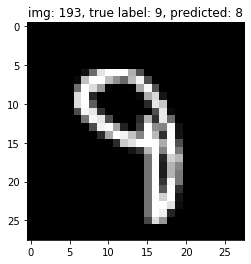

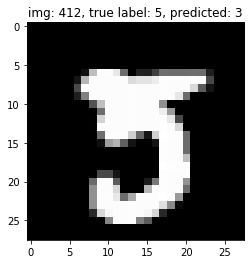

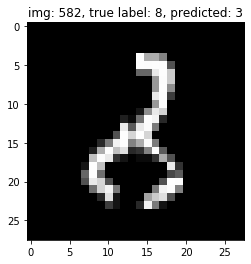

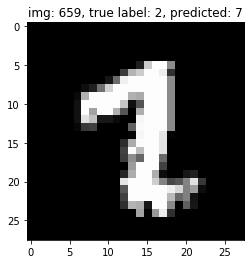

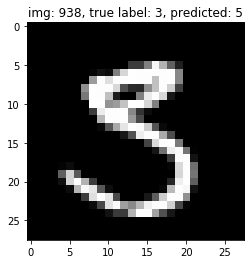

In [8]:
image_ids = [193, 412, 582, 659, 938]
for image_id in image_ids:
    prediction = np.argmax(model.predict(x_test[image_id]), axis=1).item()
    plot_mnist(x_test, label_test, image_id, prediction)

In [9]:
import heapq
def get_topk_activations_given_images(model, dataset, image_ids, layer_name, k):
    res = list()
    image_samples = list()
    for image_sample_id in image_ids:
        image_samples.append(dataset[image_sample_id])
    layer_result_image_samples = model.get_layer_result_by_layer_name(image_samples, layer_name)
    for idx, image_sample_id in enumerate(image_ids):
        heap = list()
        for neuron_idx, activation in np.ndenumerate(layer_result_image_samples[idx]):
            if len(heap) < k:
                heapq.heappush(heap, (activation, neuron_idx))
            elif (activation, neuron_idx) > heap[0]:
                heapq.heapreplace(heap, (activation, neuron_idx))
        res.append(sorted(heap, reverse=True))
    return res

In [10]:
image_ids = [659]
k_global = 20
topk_activations = get_topk_activations_given_images(model, x_test, image_ids, layer_name, k_global)
topk_activations

[[(2.2470708, (1, 1, 374)),
  (1.9390903, (0, 0, 113)),
  (1.901135, (0, 0, 358)),
  (1.8457981, (1, 0, 335)),
  (1.8241946, (1, 1, 62)),
  (1.772685, (1, 0, 182)),
  (1.7536623, (1, 1, 129)),
  (1.7496965, (0, 0, 95)),
  (1.7491627, (1, 0, 441)),
  (1.6753776, (1, 1, 177)),
  (1.6667688, (0, 0, 46)),
  (1.6587315, (0, 1, 340)),
  (1.6440473, (0, 1, 285)),
  (1.6398696, (1, 1, 428)),
  (1.6205437, (0, 1, 365)),
  (1.6141272, (0, 1, 461)),
  (1.575814, (0, 0, 245)),
  (1.5589457, (0, 0, 45)),
  (1.552143, (0, 1, 336)),
  (1.5128994, (0, 1, 379))]]

In [11]:
from topk_similar_images_given_neuron_group_reverse_index_with_guarantee import answer_query_with_guarantee
from NeuronGroup import NeuronGroup

image_sample_id = 659
layer_id = all_layer_names.index(layer_name)
# neuron_group = NeuronGroup(layer_id, [(1, 2), (1, 2), (374, 375)])
neuron_group = NeuronGroup(layer_id, [(0, 2), (0, 2), (374, 375)])

In [12]:
top_k, exit_msg = answer_query_with_guarantee(model, x_test, rev_idx, rev_idx_idx, image_sample_id, neuron_group, k_global, batch_size=1000)

top_k = sorted(top_k)
top_k, exit_msg

round 999: size of image batch into NN: 1000
======================= TA exited =======================


([(-0.091581345, 1194),
  (-0.091503136, 1984),
  (-0.08956289, 3418),
  (-0.08782005, 4540),
  (-0.078102425, 5649),
  (-0.070605755, 468),
  (-0.07052374, 3647),
  (-0.06433153, 3166),
  (-0.06298206, 5959),
  (-0.061490536, 3055),
  (-0.05361778, 7902),
  (-0.04478979, 5906),
  (-0.043471187, 667),
  (-0.031000614, 4861),
  (-0.017911911, 605),
  (-0.017807484, 4400),
  (-0.017260551, 2523),
  (-0.01442194, 415),
  (-0.0037016869, 124),
  (-0.0, 659)],
 'TA exited, image re-run: 1000')

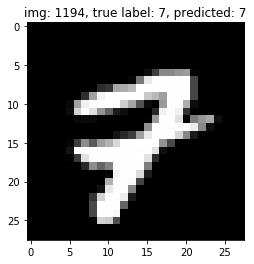

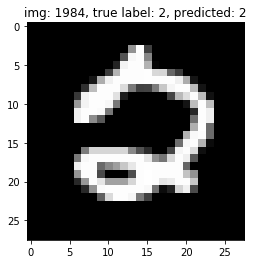

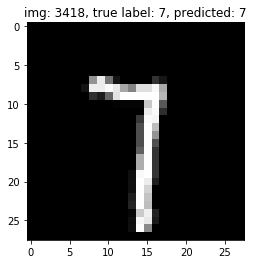

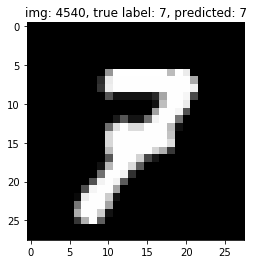

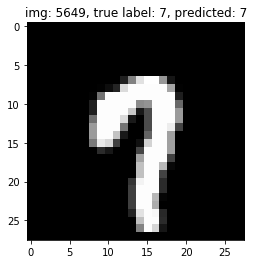

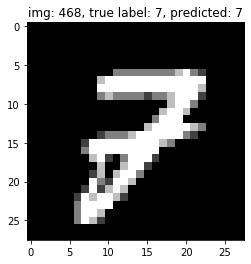

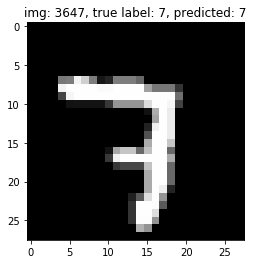

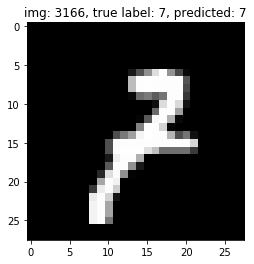

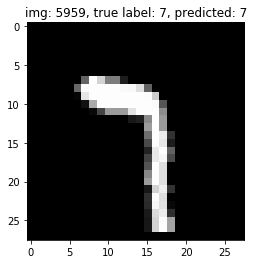

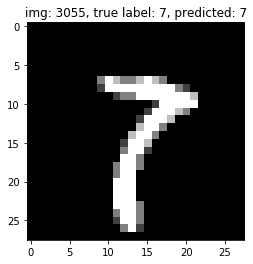

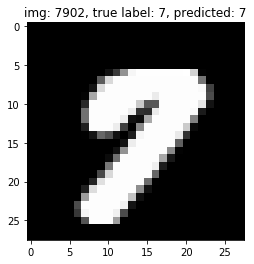

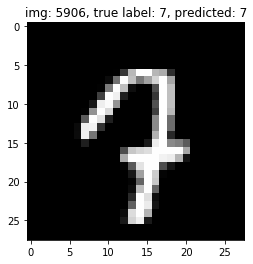

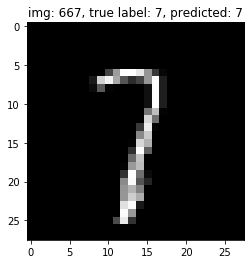

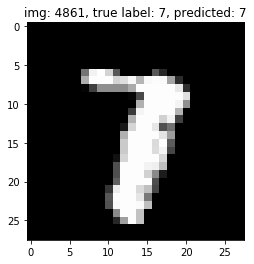

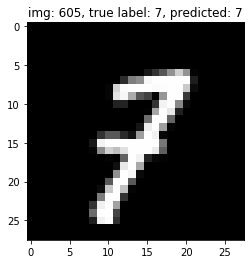

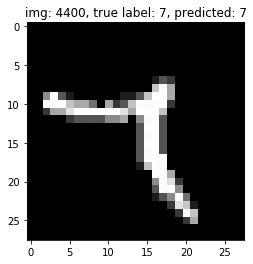

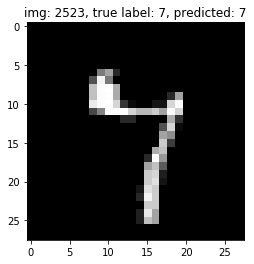

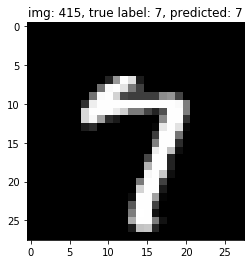

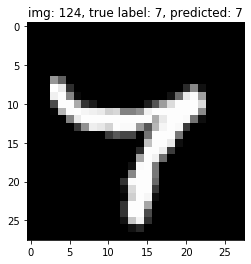

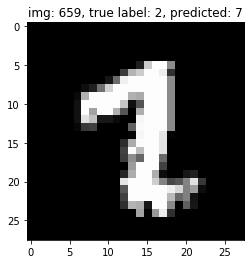

In [13]:
for neg_dist, image_id in top_k:
    prediction = np.argmax(model.predict(x_test[image_id]), axis=1).item()
    plot_mnist(x_test, label_test, image_id, prediction)

In [14]:
def predict_2_as_7(image_id):
    return label_predicted[image_id] == 7 and label_test[image_id] == 2

def predict_7_as_7(image_id):
    return label_predicted[image_id] == 7 and label_test[image_id] == 7

def predict_2_as_2(image_id):
    return label_predicted[image_id] == 2 and label_test[image_id] == 2

def predict_7_as_2(image_id):
    return label_predicted[image_id] == 2 and label_test[image_id] == 7

In [15]:
top_k, exit_msg = answer_query_with_guarantee(model, x_test, rev_idx, rev_idx_idx, image_sample_id, neuron_group, k_global, batch_size=1000, where=predict_2_as_7)
top_k = sorted(top_k)
top_k, exit_msg

([(-0.13228035, 9664), (-0.09374541, 4176), (-0.0, 659)],
 'Boundary reached, all images re-run')

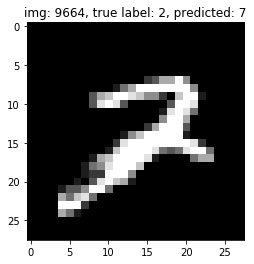

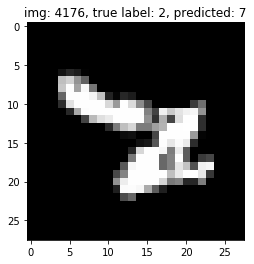

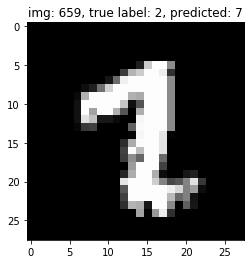

In [16]:
for neg_dist, image_id in top_k:
    prediction = np.argmax(model.predict(x_test[image_id]), axis=1).item()
    plot_mnist(x_test, label_test, image_id, prediction)

In [17]:
seven_as_two = -1
two_as_seven = -1
two_as_two = -1
seven_as_seven = -1
for image_id in range(x_test.shape[0]):
    if seven_as_two < 0 and predict_7_as_2(image_id):
        seven_as_two = image_id
    if two_as_seven < 0 and predict_2_as_7(image_id):
        two_as_seven = image_id
    if two_as_two < 0 and predict_2_as_2(image_id):
        two_as_two = image_id
    if seven_as_seven < 0 and predict_7_as_7(image_id):
        seven_as_seven = image_id
    if seven_as_two > 0 and two_as_seven > 0 and two_as_two > 0 and seven_as_seven > 0:
        break

In [18]:
image_ids = [two_as_two, seven_as_seven, two_as_seven, seven_as_two]

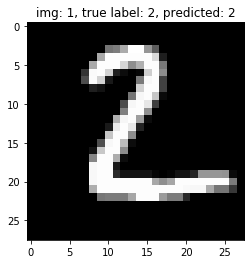

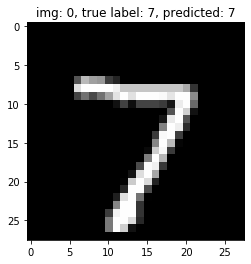

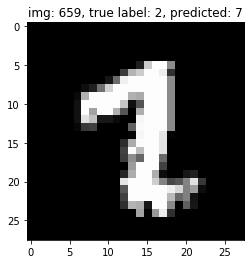

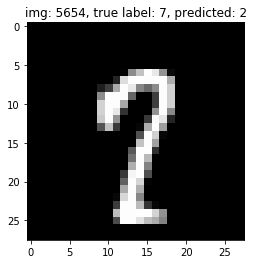

In [19]:
for image_id in image_ids:
    prediction = np.argmax(model.predict(x_test[image_id]), axis=1).item()
    plot_mnist(x_test, label_test, image_id, prediction)

In [20]:
k_global = 20
topk_activations = get_topk_activations_given_images(model, x_test, image_ids, layer_name, k_global)
topk_activations

[[(4.8707347, (1, 0, 224)),
  (4.747963, (1, 1, 205)),
  (4.7386675, (0, 1, 187)),
  (4.6761374, (1, 0, 335)),
  (4.4330807, (0, 1, 39)),
  (4.2748346, (1, 0, 322)),
  (4.244879, (1, 0, 424)),
  (4.1097507, (0, 1, 14)),
  (4.077998, (0, 0, 194)),
  (4.0133243, (1, 0, 441)),
  (3.971671, (1, 1, 271)),
  (3.8842707, (1, 1, 351)),
  (3.8667443, (0, 1, 61)),
  (3.8560166, (1, 1, 374)),
  (3.8028178, (0, 1, 18)),
  (3.7997162, (0, 0, 45)),
  (3.7284112, (1, 0, 234)),
  (3.5818675, (1, 0, 70)),
  (3.4102292, (0, 1, 285)),
  (3.3216054, (0, 1, 287))],
 [(4.7224956, (1, 0, 450)),
  (4.4728026, (0, 0, 358)),
  (4.309978, (0, 1, 236)),
  (4.1930337, (0, 1, 108)),
  (4.16376, (0, 1, 461)),
  (4.1101885, (0, 0, 436)),
  (4.063389, (1, 1, 325)),
  (4.0506167, (0, 0, 4)),
  (4.0463285, (1, 1, 374)),
  (4.0063667, (0, 1, 507)),
  (3.9760299, (1, 1, 311)),
  (3.9736688, (1, 1, 177)),
  (3.9360483, (1, 1, 96)),
  (3.9359236, (0, 1, 342)),
  (3.927606, (1, 0, 16)),
  (3.8934286, (1, 1, 62)),
  (3.882738

In [21]:
neuron_cnt = dict()
for topk_activation in topk_activations:
    for activation, neuron_idx in topk_activation:
        if neuron_idx in neuron_cnt:
            neuron_cnt[neuron_idx] += 1
        else:
            neuron_cnt[neuron_idx] = 1
{k: v for k, v in sorted(neuron_cnt.items(), key=lambda item: item[1], reverse=True)}

{(1, 1, 374): 4,
 (1, 0, 335): 3,
 (1, 0, 441): 3,
 (0, 0, 45): 3,
 (0, 1, 285): 3,
 (1, 1, 62): 3,
 (1, 0, 224): 2,
 (0, 1, 187): 2,
 (1, 0, 424): 2,
 (0, 1, 14): 2,
 (0, 1, 18): 2,
 (1, 0, 234): 2,
 (0, 0, 358): 2,
 (0, 1, 461): 2,
 (1, 1, 177): 2,
 (0, 0, 46): 2,
 (1, 0, 182): 2,
 (0, 0, 113): 2,
 (1, 1, 129): 2,
 (0, 1, 365): 2,
 (1, 1, 205): 1,
 (0, 1, 39): 1,
 (1, 0, 322): 1,
 (0, 0, 194): 1,
 (1, 1, 271): 1,
 (1, 1, 351): 1,
 (0, 1, 61): 1,
 (1, 0, 70): 1,
 (0, 1, 287): 1,
 (1, 0, 450): 1,
 (0, 1, 236): 1,
 (0, 1, 108): 1,
 (0, 0, 436): 1,
 (1, 1, 325): 1,
 (0, 0, 4): 1,
 (0, 1, 507): 1,
 (1, 1, 311): 1,
 (1, 1, 96): 1,
 (0, 1, 342): 1,
 (1, 0, 16): 1,
 (0, 1, 170): 1,
 (0, 0, 104): 1,
 (0, 0, 95): 1,
 (0, 1, 340): 1,
 (1, 1, 428): 1,
 (0, 0, 245): 1,
 (0, 1, 336): 1,
 (0, 1, 379): 1,
 (1, 1, 261): 1,
 (0, 0, 52): 1,
 (1, 1, 226): 1,
 (1, 0, 22): 1,
 (1, 0, 369): 1}

round 999: size of image batch into NN: 1000
======================= TA exited =======================


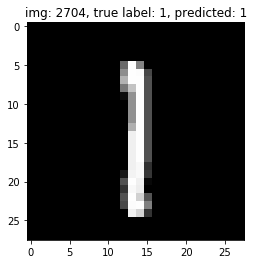

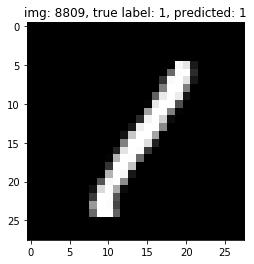

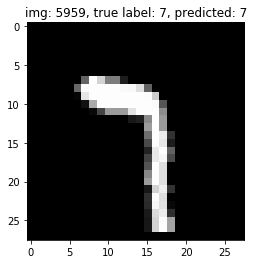

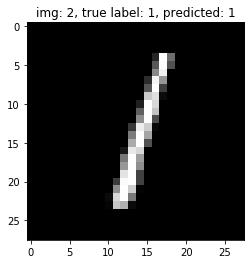

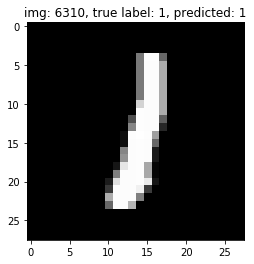

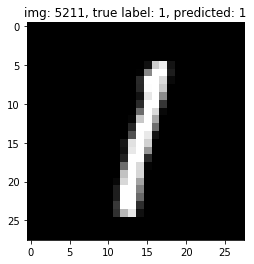

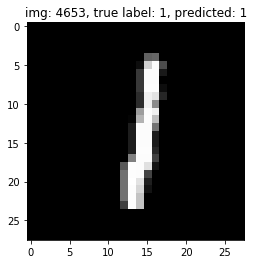

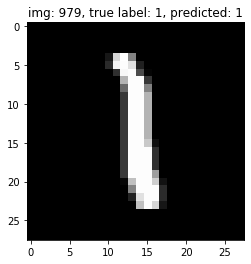

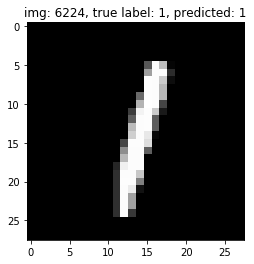

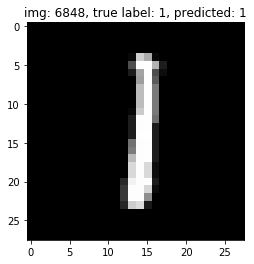

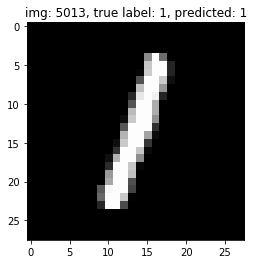

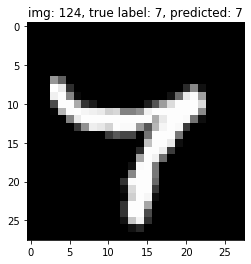

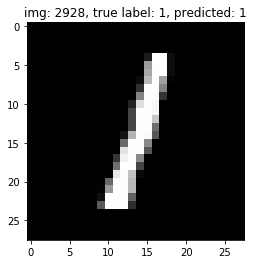

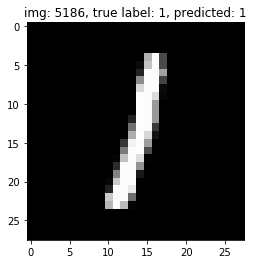

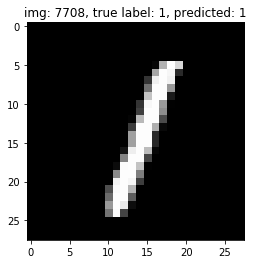

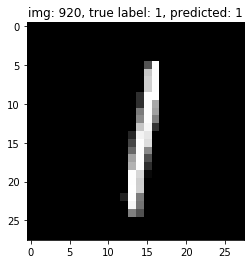

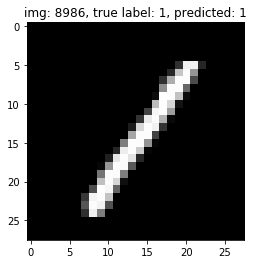

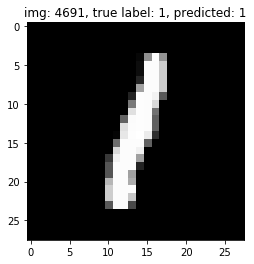

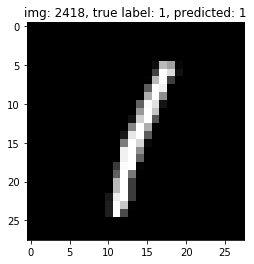

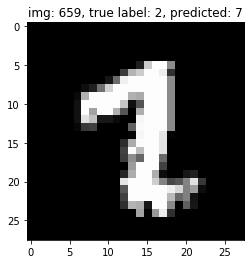

In [22]:
layer_id = all_layer_names.index(layer_name)
neuron_group = NeuronGroup(layer_id, [(1, 2), (1, 2), (374, 375)])
top_k, exit_msg = answer_query_with_guarantee(model, x_test, rev_idx, rev_idx_idx, image_sample_id, neuron_group, k_global, batch_size=1000)
top_k = sorted(top_k)
for neg_dist, image_id in top_k:
    prediction = np.argmax(model.predict(x_test[image_id]), axis=1).item()
    plot_mnist(x_test, label_test, image_id, prediction)

In [23]:
def get_topk_images_given_neuron(rev_idx, idx_of_rev_idx, layer_id, neuron_idx, k):
    key = (layer_id,) + neuron_idx
    reverse_index = rev_idx[idx_of_rev_idx[key]]
    res = list()
    i = len(reverse_index.activations_with_idx) - 1
    while i >= 0:
        res.append(reverse_index.activations_with_idx[i][1])
        i -= 1
        if len(res) >= k:
            break
    return res

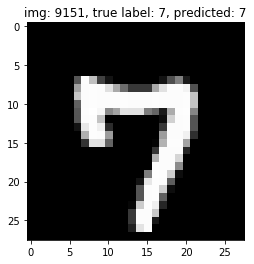

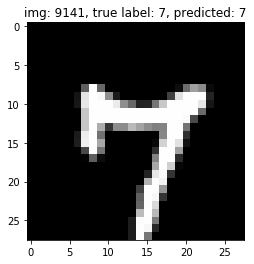

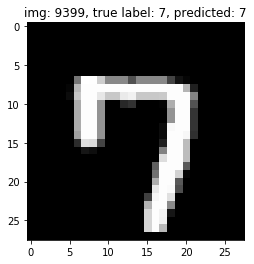

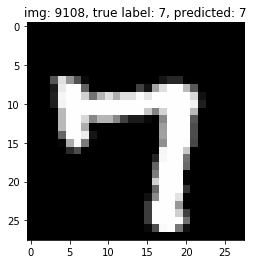

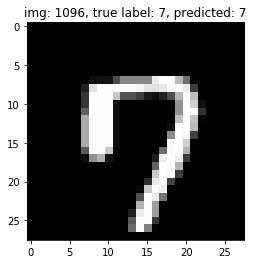

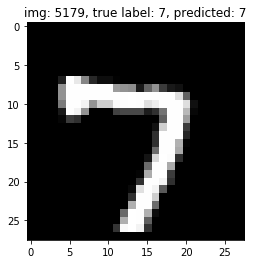

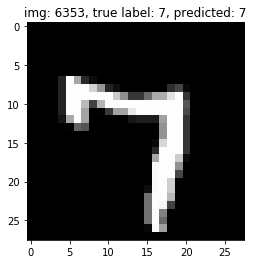

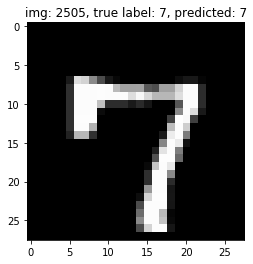

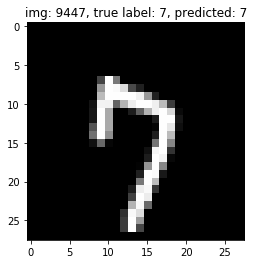

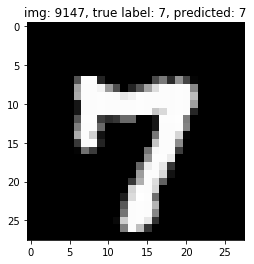

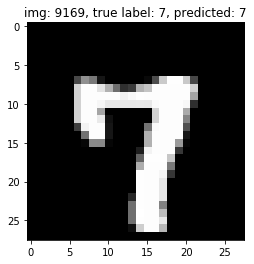

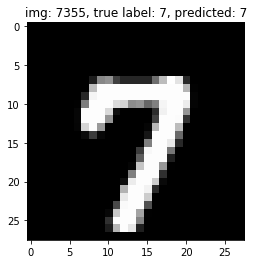

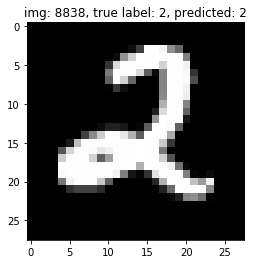

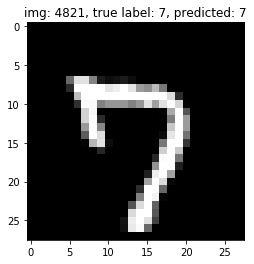

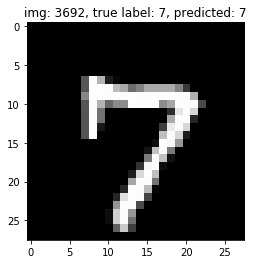

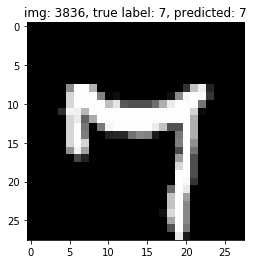

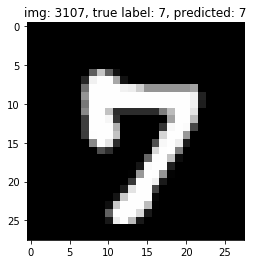

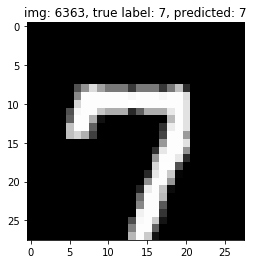

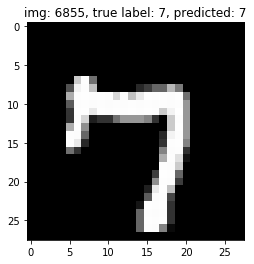

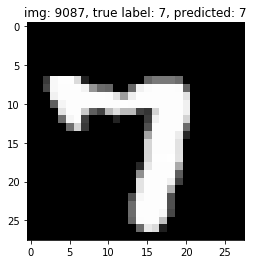

In [24]:
images_with_top_activations_for_neuron = get_topk_images_given_neuron(rev_idx, rev_idx_idx, layer_id, (1, 1, 374), k_global)
for image_id in images_with_top_activations_for_neuron:
    prediction = np.argmax(model.predict(x_test[image_id]), axis=1).item()
    plot_mnist(x_test, label_test, image_id, prediction)

round 999: size of image batch into NN: 1000
======================= TA exited =======================


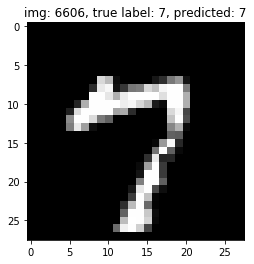

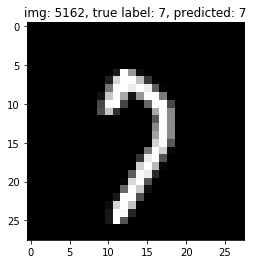

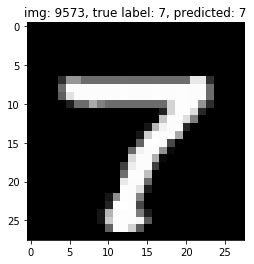

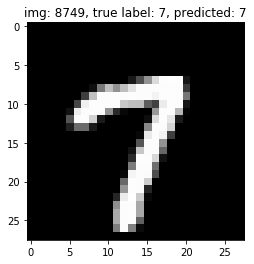

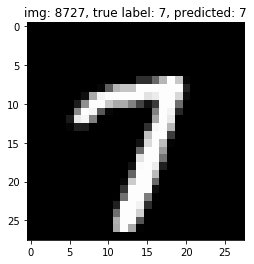

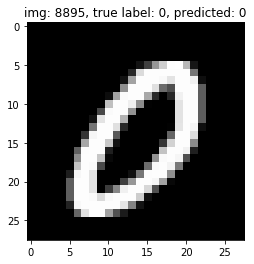

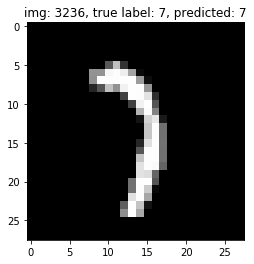

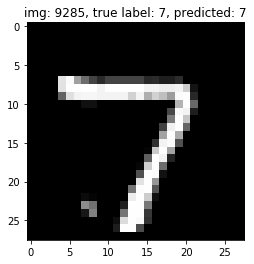

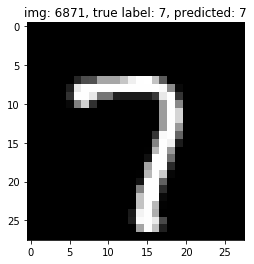

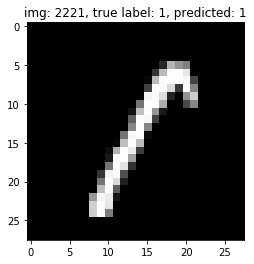

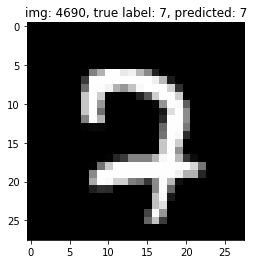

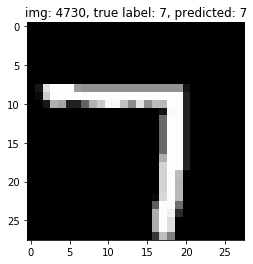

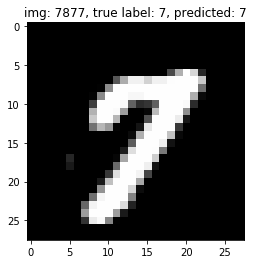

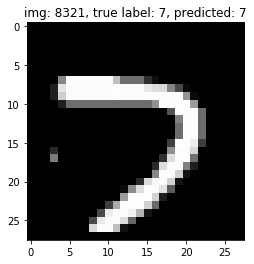

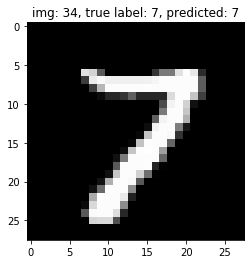

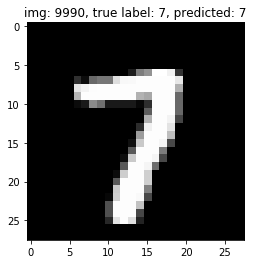

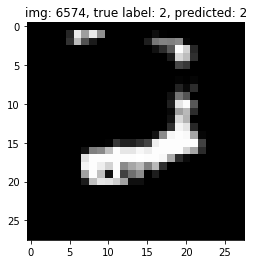

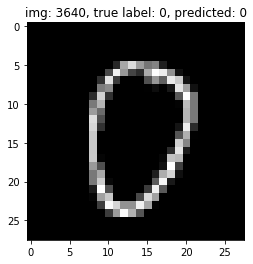

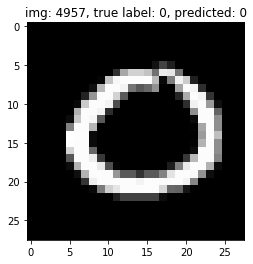

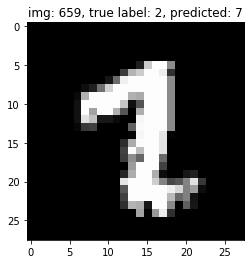

In [25]:
layer_id = all_layer_names.index(layer_name)
neuron_group = NeuronGroup(layer_id, [(1, 2), (0, 1), (441, 442)])
top_k, exit_msg = answer_query_with_guarantee(model, x_test, rev_idx, rev_idx_idx, image_sample_id, neuron_group, k_global, batch_size=1000)
top_k = sorted(top_k)
for neg_dist, image_id in top_k:
    prediction = np.argmax(model.predict(x_test[image_id]), axis=1).item()
    plot_mnist(x_test, label_test, image_id, prediction)

In [26]:
confusion_activations = [topk_activations[2], topk_activations[3]]
neuron_cnt = dict()
for topk_activation in confusion_activations:
    for activation, neuron_idx in topk_activation:
        if neuron_idx in neuron_cnt:
            neuron_cnt[neuron_idx] += 1
        else:
            neuron_cnt[neuron_idx] = 1
{k: v for k, v in sorted(neuron_cnt.items(), key=lambda item: item[1], reverse=True)}

{(1, 1, 374): 2,
 (0, 0, 113): 2,
 (1, 0, 335): 2,
 (1, 1, 62): 2,
 (1, 1, 129): 2,
 (1, 0, 441): 2,
 (0, 1, 285): 2,
 (0, 1, 365): 2,
 (0, 0, 45): 2,
 (0, 0, 358): 1,
 (1, 0, 182): 1,
 (0, 0, 95): 1,
 (1, 1, 177): 1,
 (0, 0, 46): 1,
 (0, 1, 340): 1,
 (1, 1, 428): 1,
 (0, 1, 461): 1,
 (0, 0, 245): 1,
 (0, 1, 336): 1,
 (0, 1, 379): 1,
 (1, 0, 224): 1,
 (0, 1, 187): 1,
 (1, 0, 234): 1,
 (0, 1, 18): 1,
 (1, 0, 424): 1,
 (1, 1, 261): 1,
 (0, 0, 52): 1,
 (1, 1, 226): 1,
 (1, 0, 22): 1,
 (0, 1, 14): 1,
 (1, 0, 369): 1}

round 269: size of image batch into NN: 1003
round 269: threshold: 0.457434, max in answer: 1.674805, image inferenced: 1003


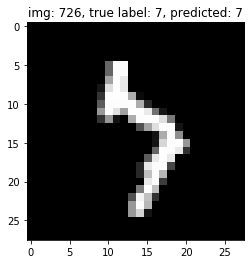

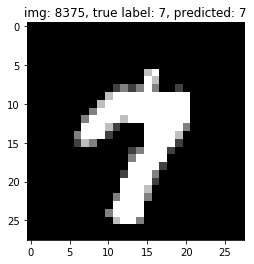

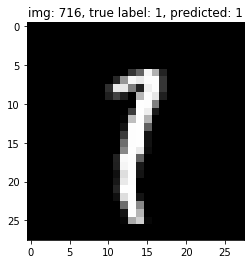

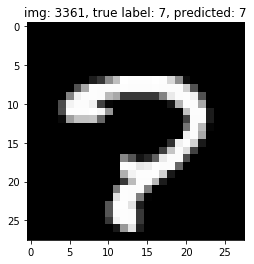

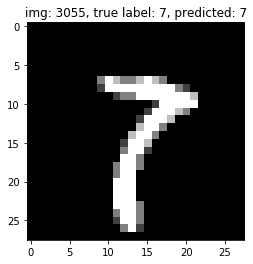

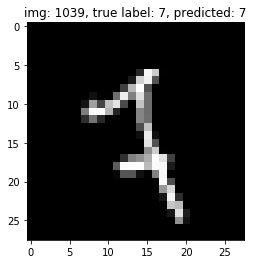

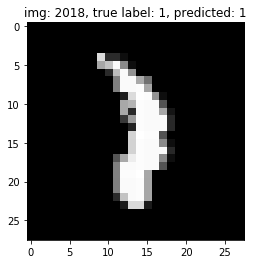

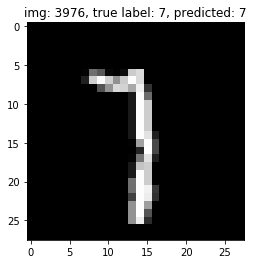

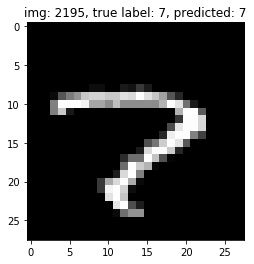

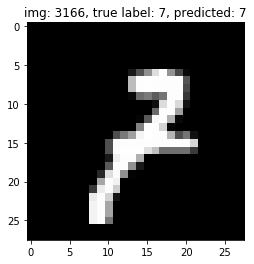

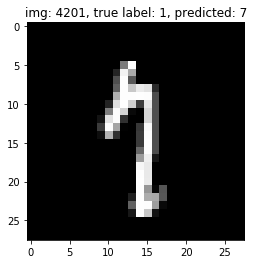

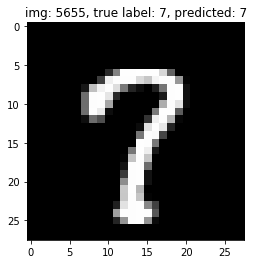

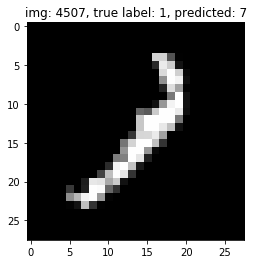

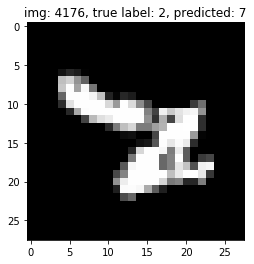

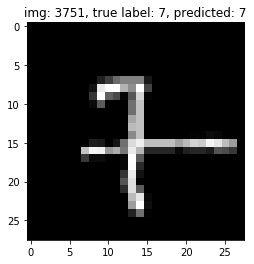

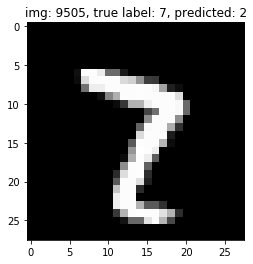

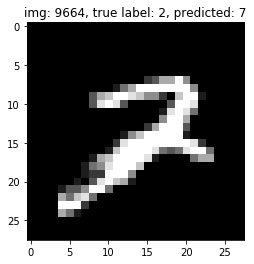

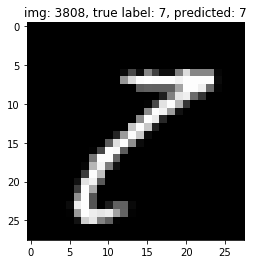

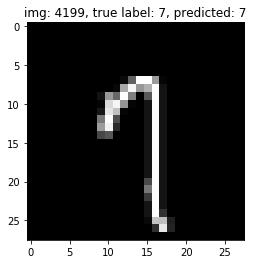

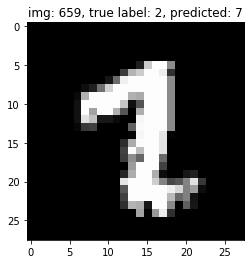

In [27]:
layer_id = all_layer_names.index(layer_name)
neuron_group = NeuronGroup(layer_id, [(1, 2), (1, 2), (62, 130)])
top_k, exit_msg = answer_query_with_guarantee(model, x_test, rev_idx, rev_idx_idx, image_sample_id, neuron_group, k_global, batch_size=1000)
top_k = sorted(top_k)
for neg_dist, image_id in top_k:
    prediction = np.argmax(model.predict(x_test[image_id]), axis=1).item()
    plot_mnist(x_test, label_test, image_id, prediction)

## TODO: This notebook needs to be updated with the lastest APIs of DeepEverest.